# Forward Rate Agreements and Interest Rate Swaps

This notebook investigates some simple examples of pricing a Forward Rate Agreement (FRA) and a Interest Rate Swap (IRS). We will look at an IRS as a series of FRAs to determine its value. 

In [2]:
# Imports
import pandas as pd
from scipy.optimize import fsolve

### Swap Rate: implied forward rates from zero/spot rates

Given a set of traded bond prices up to 3 years maturity, we can derive the fair value swap rate of a 3 year IRS. 

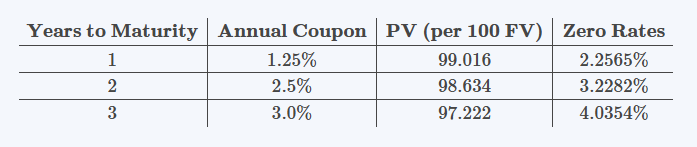

In the table we display the characteristics of the traded instruments: time to maturity, coupon rate and present value. The bonds are not zero-coupon bonds (ZCB) which implies that it's present value represents both the payout of the notional at maturity, but also its coupon payments in between. This means that for maturities longer than 1 year we should take into account the varying zero/spot rates in discounting the coupon payments. Consequently, we can't take the yield to equal the zero rate. For convenience, the zero rates are already presented in the table. Note that, in practice, one would bootstrap the zero rates from the traded bond price quotes (see zero rates notebook).

For now, we will price the IRS based on the zero curve implied forward rates. From $t=0$ to $t=1$ the forward rate is simply equal to the zero rate. From $t=1$ to $t=2$ we must solve for the 1y1y forward rate, i.e. the forward rate implied from the spot curve starting in 1y and maturing in 1y (we always denote the time to start first, followed by the time to maturity). Let the zero/spot rate for maturity $i \in \mathbb{Z}$ be defined as $s_i$. The forward rate in $i$ years for $j$ years is denoted as $f_{ij}$. It must hold, by no-arbitrage, that 

$$ (1 + f_{01}) (1 + f_{11}) = (1 + s_{2})^2, $$

where $f_{01} = s_{1}$. So, solving for $f_{11}$ we get

$$ f_{11} = \left( \frac{(1 + s_{2})^2}{(1 + s_{1})^1} - 1 \right)^{\frac{1}{1}}, $$

where we indicated the years involved in the 1 year forward rates just to highlight that these numbers would come into play if the time in the forward rate is less clean than in this example. 

In [3]:
# zero/spot rates
s_1 = 0.022565
s_2 = 0.032282
s_3 = 0.040354

# forward rate from t=0 to t=1
f_01 = s_1

# forward rate from t=1 to t=2
f_11 = ( (1 + s_2)**2 / (1 + f_01)**1 - 1 )**(1/1)

For the last forward rate we solve

$$ (1 + f_{01}) (1 + f_{11}) (1 + f_{21}) = (1 + s_{3})^3, $$

which gives

$$ f_{21} = \frac{(1 + s_{3})^3}{(1 + f_{01}) (1 + f_{11})} - 1, $$

where this time, for notational ease, I omitted the time component in the 1-year forward rates (but this is implicitly still there, and for periods deviating from precisely 1 year, this is highly important to take into account).

In [4]:
f_21 = (1 + s_3)**3 / ( (1 + f_01) * (1 + f_11) ) - 1
f_21

0.05668785224296813

### Swap Rate: solving for the par swap rate
With the forward rates on hand we can look at the equality that must hold such that the value of the swap is zero at initiation (t=0). Small note: we write the equality assuming 1y forward rates, a swap with a 3 year maturity and with precisely 1 year increments in time. The notional is denoted as $N$. Again, by no-arbitrage it holds that

$$ \sum_{i=1}^3 \frac{f_{i-1,i}}{(1 + s_i)^i} * N = \sum_{i=1}^3 \frac{r}{(1 + s_i)^i} * N, $$

where $r$ is the fixed swap rate in the contract, for which we would like to solve. Note that the notional can be ignored in finding the swap rate, since it just cancels out. 

In [9]:
time_to_maturities = [1, 2, 3]
forward_rates = [f_01, f_11, f_21]
spot_rates = [s_1, s_2, s_3] 
notional = 10_000_000

swap_df = pd.DataFrame(index=time_to_maturities)
swap_df['time'] = time_to_maturities
swap_df['spot rates'] = spot_rates
swap_df['forward rates'] = forward_rates
swap_df

,time,spot rates,forward rates
1,1,0.022565,0.022565
2,2,0.032282,0.042091
3,3,0.040354,0.056688


In [10]:
float_pv = 0
fixed_pv = 0
swap_par_rate = 0.02

for i in range(len(forward_rates)):
    float_pv += forward_rates[i] / (1 + spot_rates[i])**(i+1) 
    fixed_pv += swap_par_rate / (1 + spot_rates[i])**(i+1)

# from the perspective of a fixed rate receiver 
swap_pv = fixed_pv - float_pv
swap_pv

-0.05582172253518368

as we can see, the present value of the swap at initiation is not equal to zero. This is to be expected, since we just inputted a random rate equal to 2% as the par swap rate. The whole idea is that we solve for this swap rate. So, we'll adjust our code to get a function, such that we can solve for the swap rate in this function by using a solver of choice.

In [11]:
def swap_pv(swap_par_rate, forward_rates, spot_rates):
    float_pv = 0
    fixed_pv = 0

    for i in range(len(forward_rates)):
        float_pv += forward_rates[i] / (1 + spot_rates[i])**(i+1) 
        fixed_pv += swap_par_rate / (1 + spot_rates[i])**(i+1)

    # from the perspective of a fixed rate receiver 
    swap_pv = fixed_pv - float_pv
    
    return swap_pv

initial_guess = 0.02
swap_par_rate = fsolve(func=swap_pv, x0=initial_guess, args=(forward_rates, spot_rates))[0]
swap_par_rate




0.039904658608858834

### Let's have a look at the cashflows

If we put our results into the dataframe, we can observe that the fixed payment is identical for each year, and the float payment is proportional to the corresponding forward rate. From here, it's also evident that the net payment in year $i$ in a swap generally doesn't equal zero, at initiation. Usually, an FRA with the same characteristics as one of the swap payments, would have zero value at initiation. This would result in a fixed rate unequal to the swap par rate in our example. However, for swaps, the par swap rate is chosen such that the net present value of the entire contract is zero. This means that some of it's net payments are positive and some are negative at initiation, but its sum equals zero. We show this below. 

So, in our case, we can think of the fixed rate in the FRAs as identical to the swap par rate. In this case, the value of the FRA would just be unequal to zero at initiation. 

 

In [12]:
swap_df['notional'] = notional
swap_df['discount'] = 1 / (1 + swap_df['spot rates'])**swap_df['time']

swap_df['fixed payment'] = swap_par_rate * notional 
swap_df['float payment'] = swap_df['forward rates'] * notional
swap_df['net payment'] = swap_df['fixed payment'] - swap_df['float payment']

swap_df['present value fixed'] = swap_df['fixed payment'] * swap_df['discount']
swap_df['present value float'] = swap_df['float payment'] * swap_df['discount']
swap_df['present value net'] = swap_df['present value fixed'] - swap_df['present value float']
swap_df


,time,spot rates,forward rates,notional,discount,fixed payment,float payment,net payment,present value fixed,present value float,present value net
1,1,0.022565,0.022565,10000000,0.977933,399046.586089,225650.000000,173396.586089,390240.802383,220670.568619,169570.233764
2,2,0.032282,0.042091,10000000,0.938433,399046.586089,420913.365155,-21866.779067,374478.501748,394999.009750,-20520.508002
3,3,0.040354,0.056688,10000000,0.888089,399046.586089,566878.522430,-167831.936341,354388.953136,503438.678898,-149049.725762


In [ ]:
# IRS has a value of zero at initiation
present_value_swap = swap_df['present value net'].sum()
present_value_swap

-8.731149137020111e-11